In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [17]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [18]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
# img_to_array fonksiyonu görseli matrise çeviriyor
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam,RMSprop
import datetime
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from keras.applications.nasnet import NASNetLarge, preprocess_input,decode_predictions
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import numpy as np
import random
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
data_dir= "/content/gdrive/MyDrive/Kaggle/COVID-19 Radiography Database/"
covid_data_path = data_dir+"COVID-19/"
normal_data_path = data_dir+"NORMAL/"

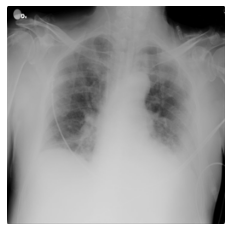

In [20]:
img = load_img(covid_data_path+"COVID-19 (1).png")
plt.imshow(img)
# matristeki x ,y axisleri kaldırdık
plt.axis("off")
plt.show()

In [21]:
img_height, img_width=331,331
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3,rotation_range=0.1,zoom_range=0.2,preprocessing_function=preprocess_input) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    color_mode="rgb") # set as training data
    
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    subset='validation') # set as validation data

Found 1740 images belonging to 2 classes.
Found 744 images belonging to 2 classes.


NasNetLarge

In [22]:
base_model= NASNetLarge(include_top=False,weights="imagenet")
x= base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64,activation="relu")(x)
x = Dropout(0.1)(x)
predictions= Dense(1,activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layers in base_model.layers:
    layers.trainable = False
    
# Defining optimizer
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [23]:
trainer=model.fit(train_generator,validation_data=validation_generator,epochs=5,callbacks=[tensorboard_callback])

Epoch 1/5
109/109 [==============================] - 125s 1s/step - loss: 0.1663 - accuracy: 0.9113 - val_loss: 0.0596 - val_accuracy: 0.9785
Epoch 2/5
109/109 [==============================] - 103s 944ms/step - loss: 0.0665 - accuracy: 0.9791 - val_loss: 0.0633 - val_accuracy: 0.9772
Epoch 3/5
109/109 [==============================] - 102s 942ms/step - loss: 0.0573 - accuracy: 0.9790 - val_loss: 0.0459 - val_accuracy: 0.9839
Epoch 4/5
109/109 [==============================] - 103s 944ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0301 - val_accuracy: 0.9892
Epoch 5/5
109/109 [==============================] - 103s 942ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0387 - val_accuracy: 0.9933


In [ ]:

%tensorboard --logdir logs/fit

In [25]:
z,x=model.evaluate(validation_generator)

744/744 [==============================] - 44s 59ms/step - loss: 0.0310 - accuracy: 0.9919


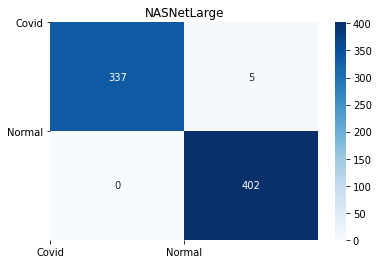

739


In [30]:
import seaborn as sn
nb_samples = len(validation_generator)
y_pred = []
y_act=[]
p=0
for i in range(nb_samples):
  x,y=validation_generator.next()
  y_act.append(y)
  if model.predict(x)>0.5:
    y_pred.append(1)
  else : y_pred.append(0)
  if y_pred[i]==y_act[i]:
    p+=1
cm=confusion_matrix(y_act,y_pred)

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.title("NASNetLarge")
plt.xticks([0,1], ["Covid","Normal"])
plt.yticks([0,1], ["Covid","Normal"],rotation=0)
plt.show()
print(p)

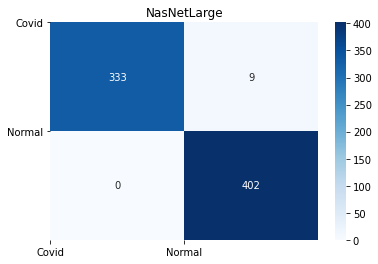

In [27]:
cm=confusion_matrix(y_act,y_pred)

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.title("NasNetLarge")
plt.xticks([0,1], ["Covid","Normal"])
plt.yticks([0,1], ["Covid","Normal"],rotation=0)
plt.show()

In [32]:
names= ['Covid-19','Sağlıklı']
print(classification_report(y_act, y_pred, target_names=names))

              precision    recall  f1-score   support

    Covid-19       1.00      0.99      0.99       342
    Sağlıklı       0.99      1.00      0.99       402

    accuracy                           0.99       744
   macro avg       0.99      0.99      0.99       744
weighted avg       0.99      0.99      0.99       744

